# Проект: Система поиска подходящих товаров на основе дообученной CLIP модели


## Постановка задачи

Нужно реализовать такую систему: пользователь описывает вещь словами, система находит и показывает наиболее близкие позиции из базы. Компания выходит на международный рынок, поэтому система будет работать на английском языке.

Нужно:
- дообучить модель CLIP на датасете товаров из магазинов одежды,
- реализовать систему поиска изображений товаров по текстовым запросам.

## Критерии успеха

- Целевые значения **среднего CLIP** score должны быть **выше 30**.
- Ожидаемый результат: реализована поисковая система, способная принимать текстовые запросы и возвращать наиболее релевантные изображения из датасета. Система должна работать эффективно, то есть не пересчитывать каждый раз векторные представления картинок.

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных
[Ссылка](https://www.kaggle.com/datasets/nirmalsankalana/fashion-product-text-images-dataset) на датасет.

Датасет содержит картинки и таблицу `data.csv`.

В этой таблице такие поля: 
- `image` — название файла изображения в папке с изображениями.
- `description` — описание элемента одежды, изображённого на картинке.
- `display name` — название элемента на картинке.
- `category` — категория элемента одежды.

В проекте вам понадобятся только первые два столбца: `image` — для визуальных данных, `description` — для текстовых.

## Инициализация

In [1]:
# 👷🚧🚧🚧🚧🚧 просто для дебага без GPU - переключить при итоговом обучении и замере в False:
JUST_DEBUG_WO_GPU = True
DEBUG_MAX_ELEMENTS = 10

RANDOM_STATE = 42

DATA_CSV_PATH = "archive/data.csv"
IMAGES_PATH = "archive/data/"

MODEL_NAME = "openai/clip-vit-base-patch32"


### Импорт библиотек

In [29]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from tqdm.notebook import tqdm

C:\Users\Papa\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Fine-tuning CLIP

## Загрузка и исследовательский анализ данных


In [3]:
df = pd.read_csv(DATA_CSV_PATH).drop(columns=['display name', 'category'])

In [4]:
pd.options.display.max_colwidth = 1000

In [5]:
df.head()

,image,description
0,3238.jpg,"Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only"
1,43044.jpg,"Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit"
2,54018.jpg,"Teal handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back"
3,8141.jpg,"Perfectly stylish, this fastrack analog wrist watch is a great buy for those who enjoy performance and style. With excellent touches and comfort, this watch makes for an excellent daily wear. Case diameter : 30 mm Case thickness : 5 mm Dial shape : Square Plastic case with a fixed bezel for added durability, style and comfort Leather strap with stitch detailing, brand name printed on the inner part and a tang clasp Silver dial in a radiating pattern with minute marking in pink from 6 o& rsquo clock to 12 o& rsquo clock position, brand name at 3 o& rsquo clock position and brand logo at 12 o& rsquo clock position Quartz movement of time display with carved out hour and minute hands Screw to reset time Solid case back made of stainless steel for enhanced durability Water resistance at 30 meters, allowing you to use it even when swimming"
4,22245.jpg,"These id mid-top chukka shoes add a fresh spin on a classic style with its wide midsole. The humble sneaker reached a new high with this casual shoe, with its contrasting textures and subtle colour map. Wear this with a crisp shirt, a half zippered sweater and a jacket or blazer on top to achieve the perfect layered look. Pair this with your favourite jeans or chinos. Upper Low top suede upper with synthetic overlay on the heel collar Perforations in the midfoot region for ventilation Central lace ups Padded tongue and collar Mesh lining Contrast stitch detailing Midsole Thick EVA midsole Outsole Rubber outsole with a stacked heel and grooves Shoe care Wipe with a dry cloth to remove dust"


Сразу отделим тестовую выборку, чтобы её не касалась предобработка и очистка.

In [6]:
df_train, df_val = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39996 entries, 0 to 39995
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        39996 non-null  object
 1   description  39743 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


Есть пустые поля с описаниями. Такие образцы нам не нужны - удалим их:

In [9]:
df_train = df_train.dropna()

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39743 entries, 0 to 39995
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        39743 non-null  object
 1   description  39743 non-null  object
dtypes: object(2)
memory usage: 931.5+ KB


Изучим дубликататы датафейрма:

In [11]:
df_train['image'].duplicated().sum()

0

In [12]:
df_train['description'].duplicated().sum()

4549

In [13]:
df_train['description'].value_counts()

description
-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     839
Style Note                                                                        

Дубликаты есть, в т. ч. без значимых описаний. Удалим такие:

In [14]:
english_pattern = r'[a-zA-Z]'
mask = ~df_train['description'].str.contains(english_pattern, na=False)
df_train[mask]['description'].value_counts()

description
-       839
2008      1
.         1
          1
          1
Name: count, dtype: int64

In [15]:
df_train = df_train[~mask]

In [16]:
df_train['description'].value_counts()

description
Style Note                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            109
Chip-resistant and prevents yellowing of nails Fast drying and long wearing Simple

Посмотрим на некоторые группы картинок

In [17]:
def show_images (df_arg):
    for _, row in df_arg.iterrows():
        image_path = os.path.join (IMAGES_PATH, row['image'])
    
        image = Image.open(image_path)
        
        print (f"⬇------------------- изображение {row['image']} -------------------⬇")
        wrapped_description = textwrap.fill(row['description'], width=80)
        print (wrapped_description)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

⬇------------------- изображение 44985.jpg -------------------⬇
Style Note


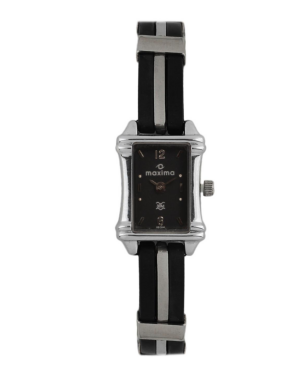

⬇------------------- изображение 45039.jpg -------------------⬇
Style Note


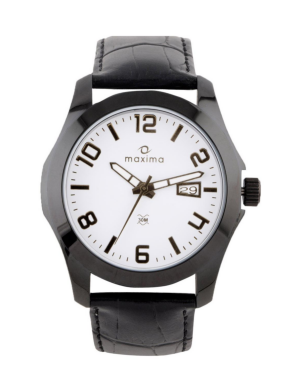

⬇------------------- изображение 52384.jpg -------------------⬇
Style Note


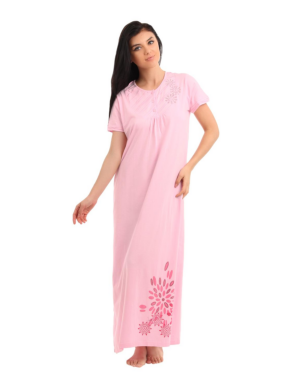

In [18]:
show_images (df_train [df_train['description'] == 'Style Note'][:3])

-- такие дубликаты удалим, т. к. описание бессмысленное, а картинки противоречивые.

In [19]:
df_train = df_train [df_train['description'] != 'Style Note']

⬇------------------- изображение 55940.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


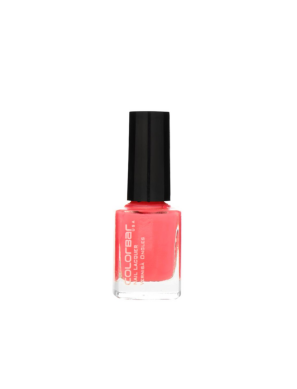

⬇------------------- изображение 55888.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


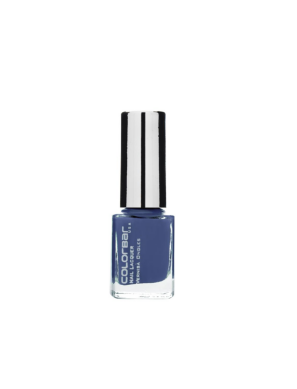

⬇------------------- изображение 55928.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


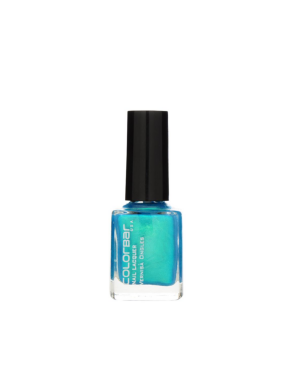

In [20]:
show_images (df_train [df_train['description'] == 'Chip-resistant and prevents yellowing of'
                 ' nails Fast drying and long wearing Simple one stroke application'][:3])

-- такие дубликаты оставим.

Посмотрим разрешения картинок:

In [21]:
def get_resolution (row):
    image_path = os.path.join (IMAGES_PATH, row['image'])
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден по пути {image_path}")
    except Exception as e:
        print(f"Произошла ошибка при обработке изображения: {e}")    


df_train [['width', 'height']] = df_train.apply(get_resolution, axis=1, result_type='expand')

In [22]:
df_train['width'].value_counts()

width
1080    38791
Name: count, dtype: int64

In [23]:
df_train['height'].value_counts()

height
1440    38791
Name: count, dtype: int64

Все изображения имеют разрешение  1080х1440

Посмотрим на несколько случайных изображений и текстов, оценим их соответствие:

In [24]:
pd.options.display.max_colwidth = 10

⬇------------------- изображение 4433.jpg -------------------⬇
Composition Wide blue and white striped polo t-shirt made of 100% cotton, with
wrangler logo stitched on left chest Fitting Comfort Wash care   Light machine
wash  Do not scrub  Do not bleach  Warm iron on reverse  Do not dry clean  Dry
flat/ reverse   Created for casual and semi-formal occasions, this white and
blue striped polo neck wrangler t-shirt gives you a corporate-yet-casual look.
Pair this front buttoned neck cotton tee with chinos and leather or suede shoes
on a casual day at work or with denims and sneakers when chilling out with
friends. Model statistics The model wears size M in t-shirts Height-6',
Shoulders-18"


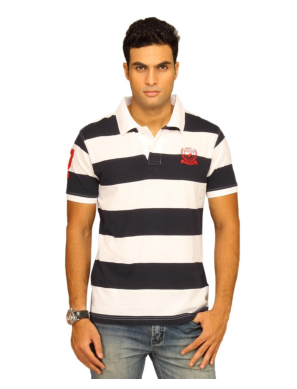

⬇------------------- изображение 5040.jpg -------------------⬇
Enjoy summer in these sleek flip flops from fila. The insole is soft while the
foamy phylon midsole makes the footwear lightweight and cushioned. The wide
straps ensure a snug Fit and the twill tape toe separators give added comfort.
The TPR outsole with 3-D branding enhances grip and stability. Upper   Lightly
padded synthetic straps stitched to the midsole  Comfortable twill tape toe
separators  Embroidery branding on the straps   Midsole   Printed cushioned
footbed for added comfort  Graphiti on the footbed for style  Visible phylon
midsole   Outsole   TPR outsole with 3-D branding for extra grip   shoe care Do
not machine wash Rub with soft, clean cloth to remove dust and dirt


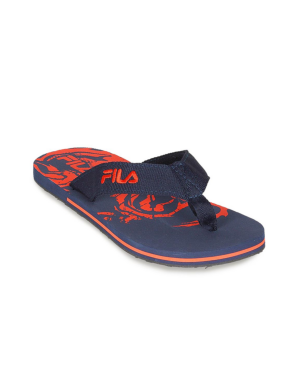

⬇------------------- изображение 52759.jpg -------------------⬇
Style Note A classic carryall is an essential that no woman can do without.
fiorelli tries to address this need with a minimalistic and elegant handbag that
effortlessly slots into your daily wardrobe. Crafted from premium leather, this
piece is specially designed and created with the highest quality standards,
ensuring that it will last for several years to come. Product Details Chocolate
brown bag with metal brand badge on the front Three zippered compartments with
one zippered pocket(has a brand patch), a slip pocket and a mobile slot in the
centre compartment Tabs with rivet detailing at the sides Paneled back and two
short handles for carrying ease Guarantee : 1yr Material and Care Leather Wipe
with clean, dry cloth to remove dirt Size Height: 24 cm Width: 33 cm Depth: 14
cm


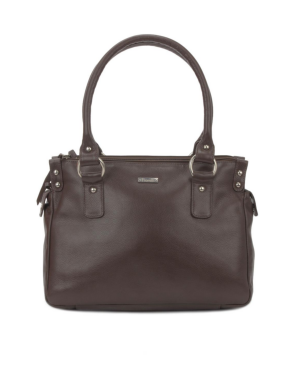

⬇------------------- изображение 24362.jpg -------------------⬇
Composition Brown printed kurta made of 100% cotton, has a mandarin collar with
a split neckline, ruffles on the shoulder and chest, three-quarter sleeves and a
vented hem Fit Regular Wash care Wash dark colours separately Do not bleach Dry
inside out in shade Warm iron The inspiration for this kurta from folklore for
women is the retro-esque fusion of the uniquely ethnic with smart workwear. The
label combines the quirky street style of India's biggest metros with classic
silhouettes. This piece epitomizes how fashion, vintage styling and comfort
unite to create the perfect Indian tunic. Those interested in colour blocking
can wear this with bright contrasting capris or pants. Others who want to keep
their look classic and chic can pair this with tonal leggings, and embellished
slippers. Model statistics The product is a size M on a model of height 5'8" and
chest 33"


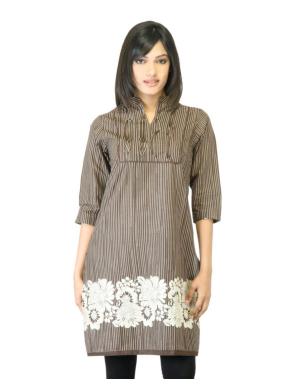

⬇------------------- изображение 59069.jpg -------------------⬇
White brassiere, non wired, seamless cups with a rosette detail between the
cups, has adjustable, slim shoulder straps, low neckline and singe hook and eye
closure at the back  Owing to intimate nature of this product it is eligible for
self-ship return only (no pick-up facility)


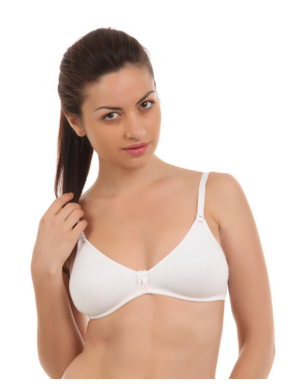

⬇------------------- изображение 28900.jpg -------------------⬇
Pink bikini briefs made of cotton/Lycra fabric, has an elastic waistband, low
rise styling and printed label on the inner  Fit Low rise  Wash care Machine
wash warm at 40 degrees with like colours Do not bleach, iron Tumble dry low
This pair of bikini briefs from enamor is crafted using premium cotton fabric
that provides quick dry breathability and no visible panty line. The cut allows
free leg movement, the fashion elastic with cushioning enhances a luxurious feel
and look, the no pinch elastic and printed label on the inside both provide
irritation-free comfort.  Model statistics Product is a size M on a model of
waist 26"


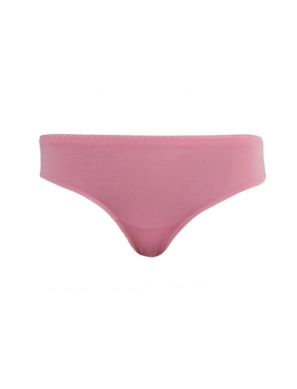

⬇------------------- изображение 17873.jpg -------------------⬇
Soft and stretchy vest made from 95% combed cotton and 5% elastane. This is an
indigo blue vest with high round neck and broad shoulders. The original two
horse Levi's logo features prominently on the back neck plus the signature red
tag is stitched to the bottom hem  Wash care Machine wash cold Do not bleach
Tumble dry low Cold iron as needed Do not dry clean  Classic vest shape and
prominent Levi's logo combine to create a ultra masculine vest to be worn under
any outfit.  The final product delivered might vary in colour and prints from
the display here.


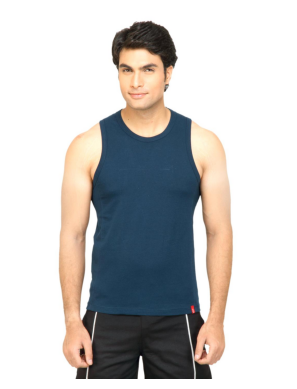

⬇------------------- изображение 50481.jpg -------------------⬇
Navy blue fashion mini briefs that have a blue, broad, elasticated waistband,
stitch detailing, printed branding on the front and slightly elasticated at the
legs for enhanced comfort  The final product delivered might vary in colour and
prints from the display here.


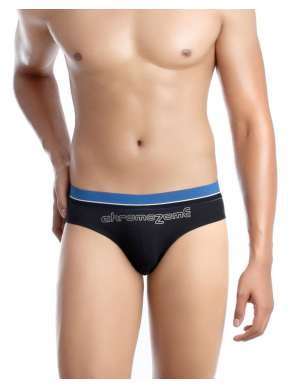

⬇------------------- изображение 20225.jpg -------------------⬇
Composition Red sweater made of a cotton/nylon blend, has a ribbed V-neck, long
sleeves with ribbed cuffs, a broad ribbed hem and brand badge appliquéd on the
left chest Fit Regular Wash care Hand wash separately using a mild detergent Do
not bleach, wring or tumble dry Flat dry in shade Mild iron; Do not iron on
decorations Top notch style and comfort, this sweater from wrangler is sure to
become a wardrobe favourite. The design and attention to detail is sure to earn
you fashion accolades, while the fabric will keep you fresh all day. Team this
with slim jeans, a shirt and casual shoes. Model statistics The product is a
size M on a model of height 5'8” and chest 33”


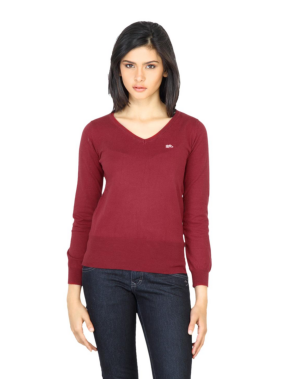

⬇------------------- изображение 6137.jpg -------------------⬇
Composition Eva,phylon,synthetic rubber shoe Care Rub surface with clean, damp
cloth to remove dust.Do not machine wash


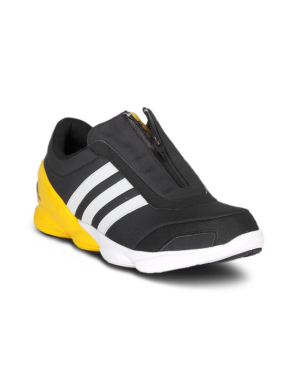

In [25]:
show_images (df_train.sample(10, random_state=RANDOM_STATE))

Описания данных 10 изображений являются корректными.

In [26]:
df_train.shape

(38791, 4)

In [28]:
df_val.shape

(4445, 2)

## Выводы по итогам EDA



- удалены образцы с пустыми или с незначищими описаниями (без букв)
- все изображения имеют разрешение  1080х1440
- всего изображения в тренировочном датасете осталось 38791, в валидационном - 4445
- описания выборочных 10 изображений являются корректными

## Подготовка датасета

Реализуем свой класс датасета, который будет подгружать картинки и соответствующие им текстовые описания.

In [ ]:
class CLIPDataset(Dataset):
    def __init__(self, df, processor, tokenizer, base_path):
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.base_path, row['image'])
        description = row['description']

        try:
            image = Image.open(image_path).convert("RGB")
            image_inputs = self.processor(images=image, return_tensors="pt")
            
            text_inputs = self.tokenizer(
                description, 
                padding="max_length", 
                truncation=True, 
                max_length=self.tokenizer.model_max_length, 
                return_tensors="pt"
            )

            # Удаляем размерность батча, добавленную процессором/токенайзером
            return {
                'pixel_values': image_inputs['pixel_values'].squeeze(),
                'input_ids': text_inputs['input_ids'].squeeze(),
                'attention_mask': text_inputs['attention_mask'].squeeze()
            }
        
        except FileNotFoundError:
            print(f"Файл не найден: {image_path}. Пропускаем.")
            return None
        except Exception as e:
            print(f"Ошибка при загрузке {image_path}: {e}. Пропускаем.")
            return None

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

## Загрузка модели

## Дообучение

# Этап 2. Реализация системы поиска товаров

## Подготовка данных

## Функция поиска товаров

## Тестирование

# Выводы

